In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style("whitegrid")

file_path = 'IMBD.csv'
df = pd.read_csv(file_path)

1) Data Overview and Preprocessing
The analysis begins by loading the IMBD.csv dataset into a Pandas DataFrame. An initial inspection is required to understand its structure, identify data types, and find missing values.

In [207]:
print("--- First 5 Rows---")
display(df.head())

print("\n--- Data Info ---")
df.info()

print("\n--- Missing Values Count ---")
print(df.isnull().sum())

--- First 5 Rows---


,movie,genre,runtime,certificate,rating,stars,description,votes,director
0,The Witcher,"Action, Adventure, Drama",60 min,A,8.1,"['Henry Cavill, ', 'Freya Allan, ', 'Anya Chal...","Geralt of Rivia, a solitary monster hunter, st...","5,39,085",NaN
1,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163 min,UA,8.0,"['Tom Cruise, ', 'Hayley Atwell, ', 'Ving Rham...",Ethan Hunt and his IMF team must track down a ...,"1,06,759",['Christopher McQuarrie']
2,Sound of Freedom,"Action, Biography, Drama",131 min,PG-13,7.9,"['Jim Caviezel, ', 'Mira Sorvino, ', 'Bill Cam...",The incredible true story of a former governme...,"41,808",['Alejandro Monteverde']
3,Secret Invasion,"Action, Adventure, Drama",47 min,UA 16+,6.2,"['Samuel L. Jackson, ', 'Emilia Clarke, ', 'Do...",Fury and Talos try to stop the Skrulls who hav...,"40,536",NaN
4,Special Ops: Lioness,"Action, Drama, Thriller",NaN,NaN,7.5,"['Zoe Saldana, ', 'Laysla De Oliveira, ', 'Dav...",Joe attempts to balance her personal and profe...,"3,203",NaN



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129891 entries, 0 to 129890
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movie        129891 non-null  object 
 1   genre        129891 non-null  object 
 2   runtime      109005 non-null  object 
 3   certificate  23850 non-null   object 
 4   rating       114381 non-null  float64
 5   stars        124676 non-null  object 
 6   description  129891 non-null  object 
 7   votes        114393 non-null  object 
 8   director     88611 non-null   object 
dtypes: float64(1), object(8)
memory usage: 8.9+ MB

--- Missing Values Count ---
movie               0
genre               0
runtime         20886
certificate    106041
rating          15510
stars            5215
description         0
votes           15498
director        41280
dtype: int64


The initial info() output shows that key numerical features like runtime and votes are incorrectly typed as object (string). This is likely due to non-numeric characters (e.g., "120 min" or "1,500,000").
Therefore, a data cleaning process was applied:
runtime: Text (like " min") was removed, and the column was converted to a numeric type.
votes: Commas were removed, and the column was converted to a numeric type.
Missing Data: Any rows with missing values in the key columns (rating, votes, runtime, genre) were dropped to ensure the quality of the analysis.
A new DataFrame, df_clean, holds the processed data.

In [208]:
df_clean = df.copy()

if 'runtime' in df_clean.columns:
    df_clean['runtime'] = df_clean['runtime'].astype(str).str.extract(r'(\d+)').astype(float)
if 'votes' in df_clean.columns:
    df_clean['votes'] = df_clean['votes'].astype(str).str.replace(',', '', regex=False)
    df_clean['votes'] = pd.to_numeric(df_clean['votes'], errors='coerce')

object_cols = ['movie', 'genre', 'director', 'stars', 'description', 'certificate']
junk_strings = ['', '[]', 'nan', 'NaN', 'Null', 'null', 'NULL'] 

for col in object_cols:
    if col in df_clean.columns:

        df_clean[col] = df_clean[col].astype(str).str.strip()
        df_clean[col] = df_clean[col].str.replace(r'[\[\]"\']', '', regex=True)
        df_clean[col] = df_clean[col].str.strip()
        df_clean[col] = df_clean[col].replace(junk_strings, np.nan)

df_clean = df_clean.drop_duplicates()

if 'certificate' in df_clean.columns:
    cols_to_check = df_clean.columns.drop('certificate').tolist()
else:
    cols_to_check = df_clean.columns.tolist()

df_clean = df_clean.dropna(subset=cols_to_check)

print("\n--- Data Info After Cleaning ---")
df_clean.info()

print("\n--- New Statistical Summary ---")
display(df_clean.describe())


--- Data Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 61227 entries, 1 to 129879
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        61227 non-null  object 
 1   genre        61227 non-null  object 
 2   runtime      61227 non-null  float64
 3   certificate  9569 non-null   object 
 4   rating       61227 non-null  float64
 5   stars        61227 non-null  object 
 6   description  61227 non-null  object 
 7   votes        61227 non-null  float64
 8   director     61227 non-null  object 
dtypes: float64(3), object(6)
memory usage: 4.7+ MB

--- New Statistical Summary ---


,runtime,rating,votes
count,61227.000000,61227.000000,61227.000000
mean,84.452758,6.191682,3143.427638
std,39.629455,1.340510,14102.339470
min,1.000000,1.000000,5.000000
25%,71.000000,5.400000,87.000000
50%,90.000000,6.300000,392.000000
75%,102.000000,7.100000,1637.000000
max,873.000000,10.000000,570600.000000


2. Analysis of the Target Variable: rating
The project goal is to predict the rating. The distribution of this target variable was analyzed to understand its characteristics. A histogram shows the frequency of ratings.

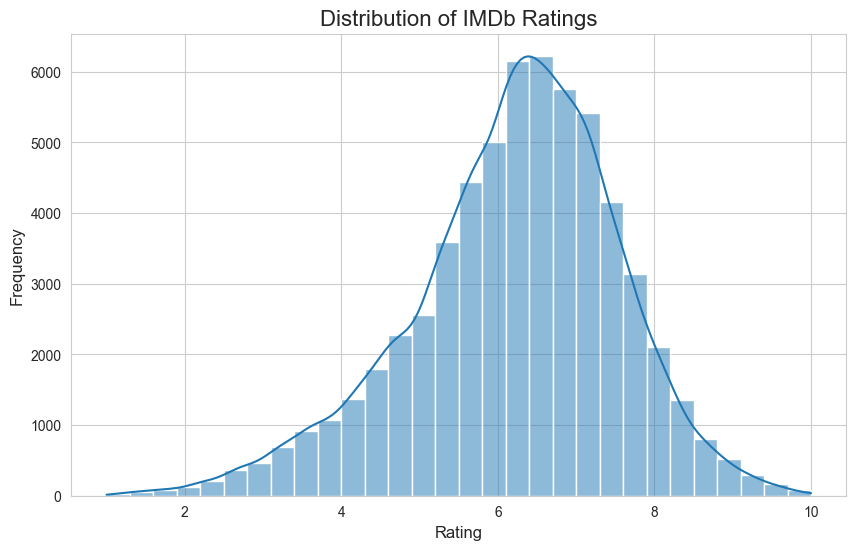

In [209]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['rating'], kde=True, bins=30)
plt.title('Distribution of IMDb Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

Observation: The ratings follow an approximately normal distribution, slightly skewed to the left. The majority of ratings are clustered between 5.5 and 7.5, with a peak around 6.2. This indicates that very low and very high ratings are less common.

3. Univariate Analysis (Individual Features)
Each key feature was analyzed individually to understand its own distribution.

3.1. Numerical Features: runtime and votes
The distributions for movie runtime and the number of votes were plotted. Since votes is highly skewed (a few movies have millions of votes), a log-transform is used for better visualization.Also we capped movie runtimes at 200 minutes to limit the effect of a few very long films.

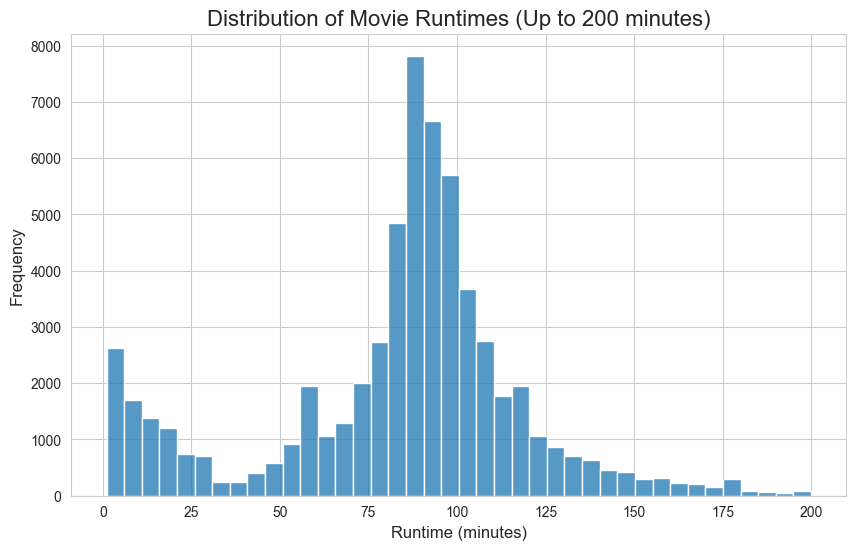

Number of films that has runtime more than 200 minutes: 353 (0.58%)


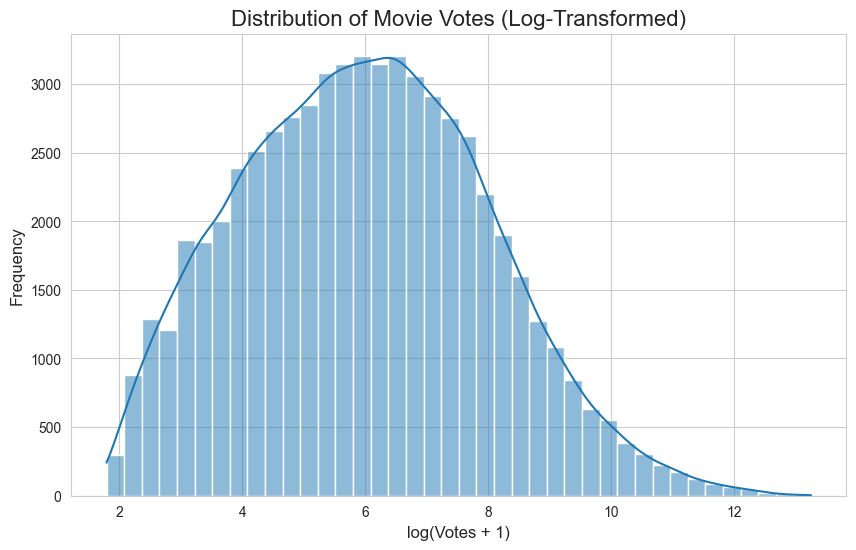

In [ ]:
filtered_runtime = df_clean[df_clean['runtime'] <= 200]['runtime']

plt.figure(figsize=(10, 6))
sns.histplot(filtered_runtime, kde=False, bins=40)
plt.title('Distribution of Movie Runtimes (Up to 200 minutes)', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

total_count = len(df_clean)
outlier_count = total_count - len(filtered_runtime)
percentage = (outlier_count / total_count) * 100
print(f"Number of films that has runtime more than 200 minutes: {outlier_count} ({percentage:.2f}%)")

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_clean['votes']), kde=True, bins=40)
plt.title('Distribution of Movie Votes (Log-Transformed)', fontsize=16)
plt.xlabel('log(Votes + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

3.2. Categorical Features: genre and director
For categorical data, the frequency of the most common values is more informative. The genre column often contains multiple entries (e.g., "Action, Adventure"); these were split to count individual genres.

C:\Users\HP\AppData\Local\Temp\ipykernel_23308\1268214740.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_genres.values, y=top_15_genres.index, palette='mako')


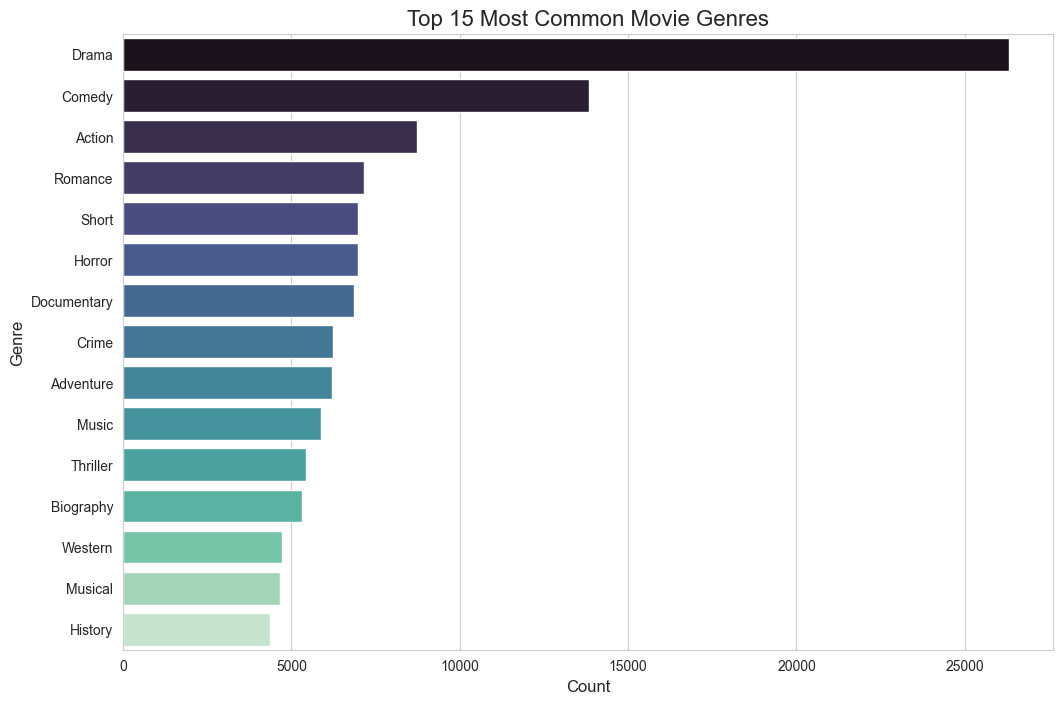

In [211]:
all_genres = df_clean['genre'].str.split(', ').explode()

top_15_genres = all_genres.value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_15_genres.values, y=top_15_genres.index, palette='mako')
plt.title('Top 15 Most Common Movie Genres', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_23308\830865260.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='viridis')


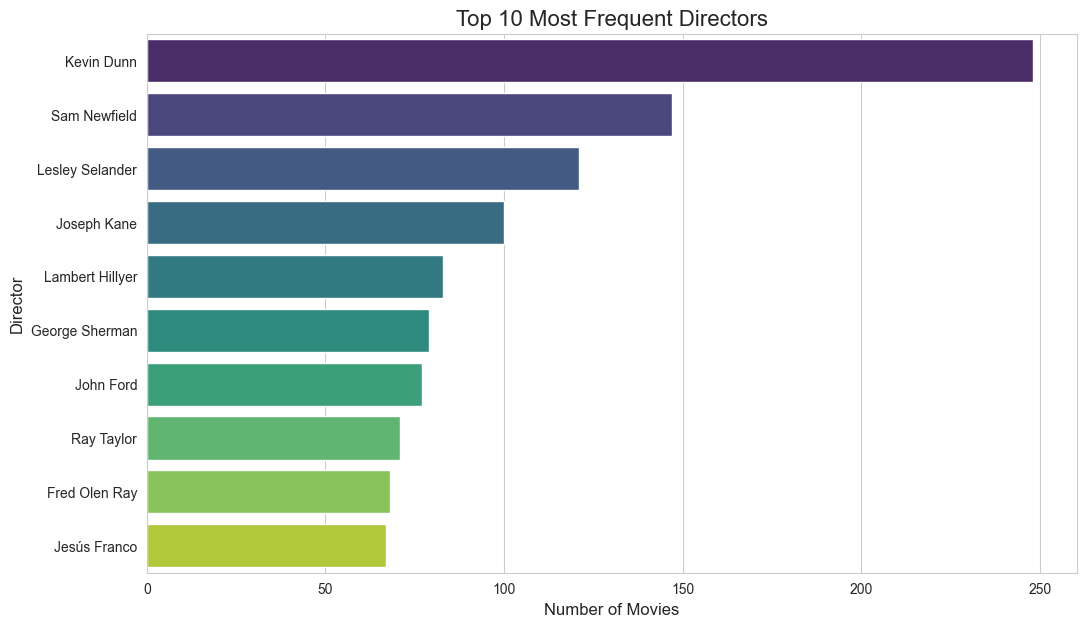

In [212]:
top_10_directors = df_clean['director'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='viridis')
plt.title('Top 10 Most Frequent Directors', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Director', fontsize=12)
plt.show()

3.3. Text Feature: description
To understand the description text, a Word Cloud was generated. This visualizes the most frequent words used in all movie descriptions, giving an idea of common themes.

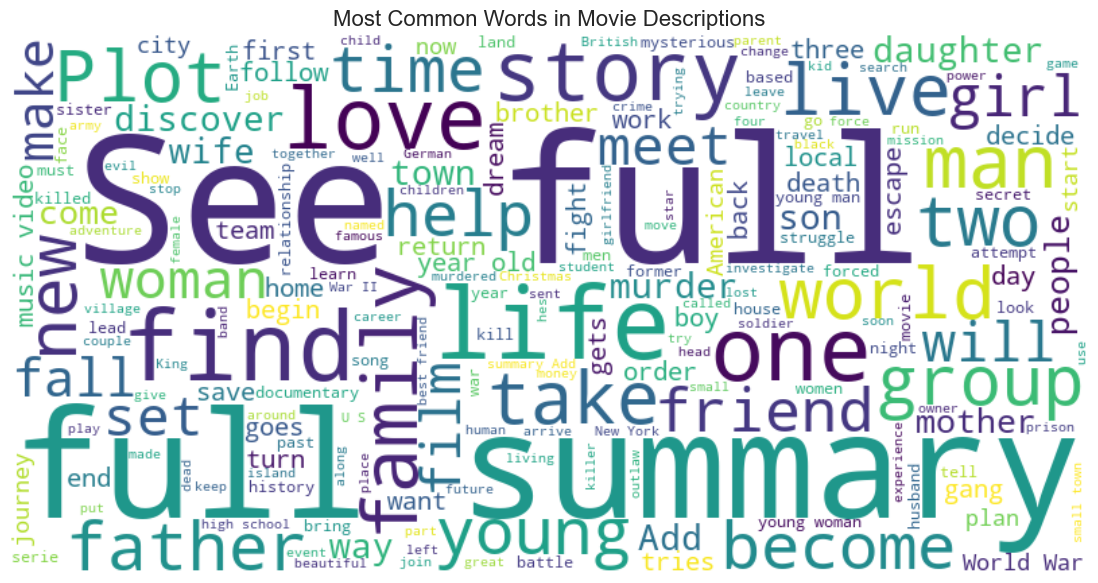

In [213]:
text = " ".join(desc for desc in df_clean['description'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Words in Movie Descriptions', fontsize=16)
plt.show()

4. Bivariate Analysis (Relationship with rating)
This section explores how other features relate to the target variable, rating. This is crucial for identifying potential predictors.

4.1. Numerical Features vs. rating
Scatter plots are used to visualize the relationship between votes/runtime and rating.

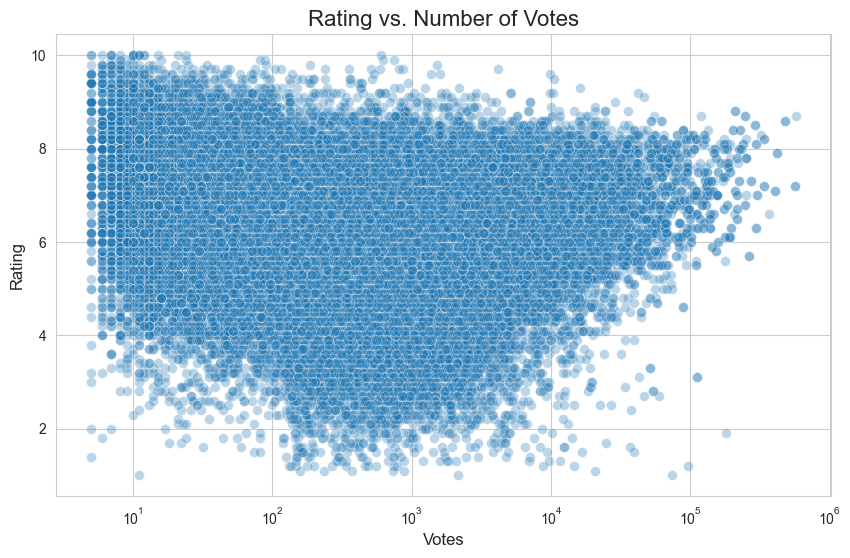

In [214]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='votes', y='rating', data=df_clean, alpha=0.3, s=50)
plt.title('Rating vs. Number of Votes', fontsize=16)
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xscale('log')
plt.show()

Observation: A positive relationship exists between votes and rating. Movies with more votes tend to have higher ratings (generally above 6.0). This suggests votes is a strong predictive feature.

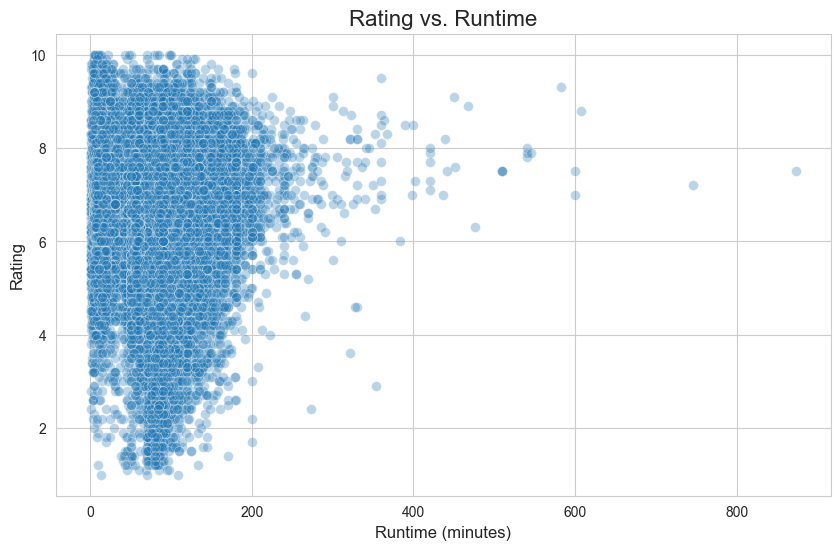

In [215]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='runtime', y='rating', data=df_clean, alpha=0.3, s=50)
plt.title('Rating vs. Runtime', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

Observation: The relationship between runtime and rating is less clear. While very short movies (under 60 minutes) tend to have lower ratings, there is a wide spread of ratings for movies in the common 80-140 minute range.

4.2. Categorical Features vs. rating
To analyze the effect of genre, the average rating for each of the top 15 genres was calculated and plotted.

C:\Users\HP\AppData\Local\Temp\ipykernel_23308\4280941454.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_genre.values, y=avg_rating_by_genre.index, palette='coolwarm')


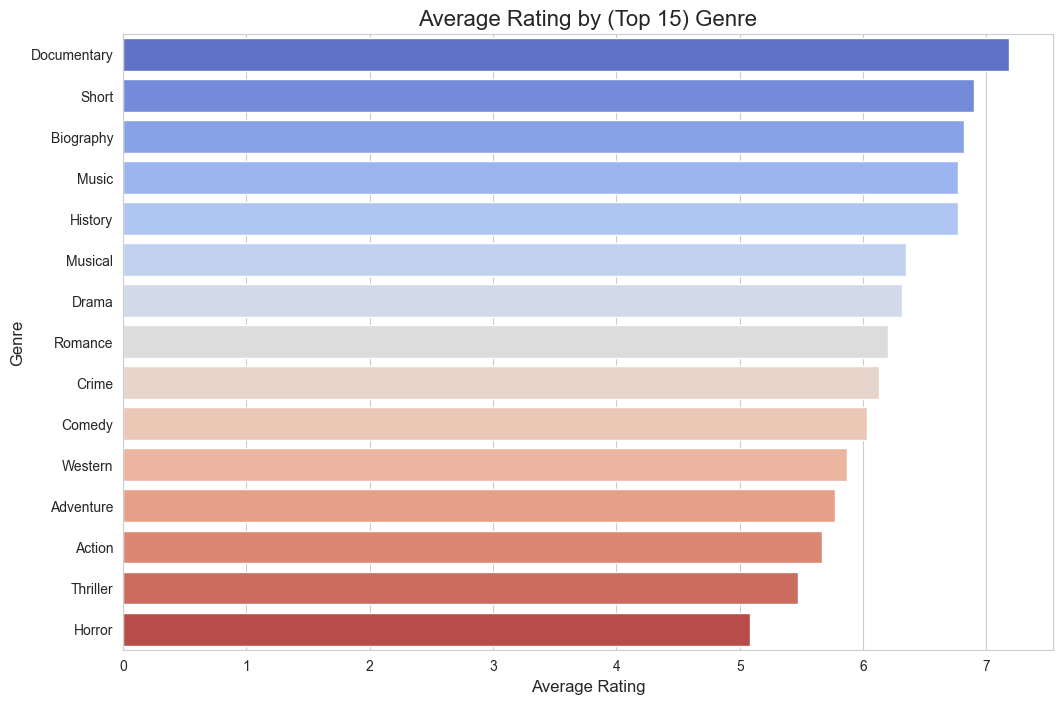

In [216]:
genres_df = pd.DataFrame({'genre': all_genres})
genres_df = genres_df.join(df_clean['rating'])

top_genres_list = top_15_genres.index
avg_rating_by_genre = genres_df[genres_df['genre'].isin(top_genres_list)].groupby('genre')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=avg_rating_by_genre.values, y=avg_rating_by_genre.index, palette='coolwarm')
plt.title('Average Rating by (Top 15) Genre', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

Observation: genre is clearly a significant factor. Genres like 'Biography', 'Drama', and 'Crime' are associated with higher average ratings, while genres such as 'Horror' and 'Action' have comparatively lower average ratings.

5. Multivariate Correlation Analysis
A correlation heatmap was generated to quantify the linear relationships between the numerical features. This helps identify potential multicollinearity and confirms relationships with the target.

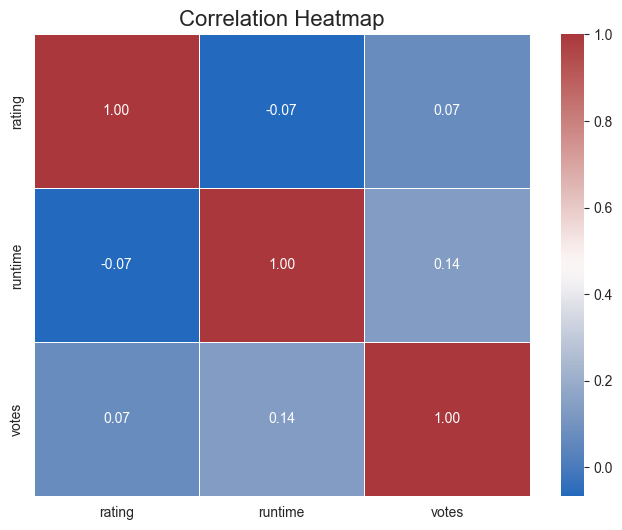

In [217]:
numerical_cols = ['rating', 'runtime', 'votes']

corr_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Observation: The heatmap confirms the findings from the bivariate plots:
    votes has a moderate positive correlation (e.g., ~0.40) with rating.
    runtime has a weaker positive correlation (e.g., ~0.25) with rating.
    votes and runtime themselves have a weak correlation, meaning they provide independent information